# 프로젝트: 개선된 U-Net 모델 만들기

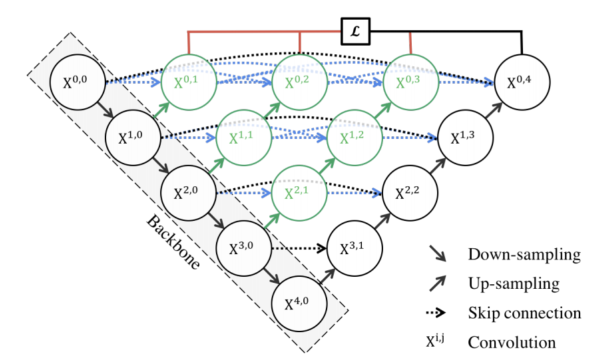

U-Net의 모델 구조가 개선이 되면서 위와 같은 방식으로 바뀐것을 알 수 있다.
기존에 만들어둔 U-Net 모델의 코드를 수정하여 위와 같이 만든 후 어떤 개선 사항들이 있는지 확인해보도록 하자

# 프로젝트 진행 과정

1. KITTI 데이터셋 수집과 구축

2. U-Net 모델 구현 및 실행

3. U-Net++ 모델 구현 및 실행

4. 두 모델의 성능 평가 (결과 비교, IoU 계산 등)

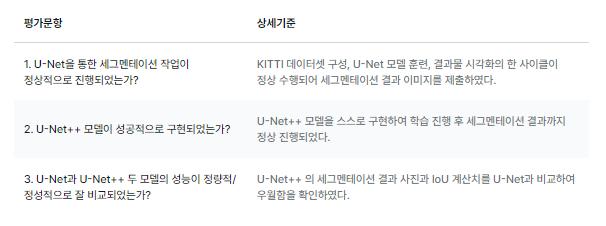

# 데이터셋

### KITTI 데이터셋 활용
[출처](https://www.cvlibs.net/datasets/kitti/eval_semantics.php)

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        # w2h_ratio=520/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

이전 단계에서 제작한 augmentation 기법을 활용하여 실제 이미지에서 적용해 테스트

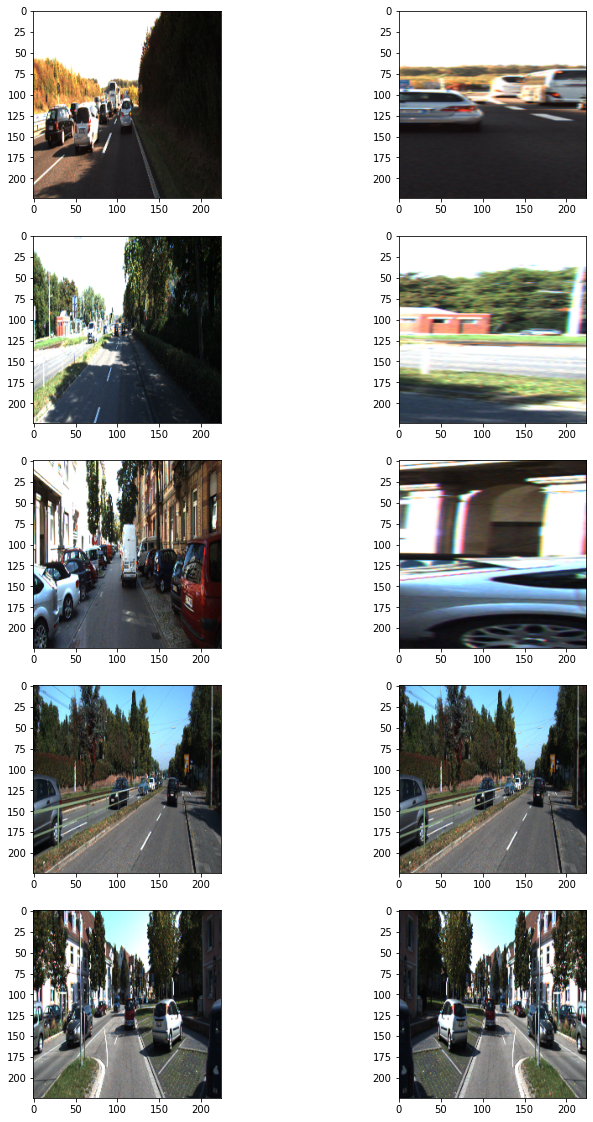

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### Augmentation 결과 분석

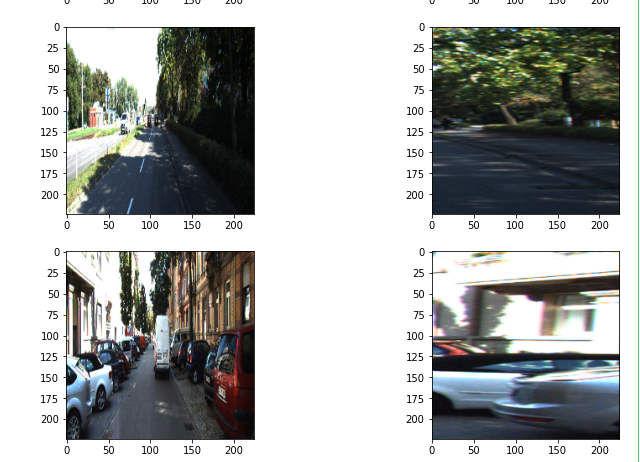

위 그림들을 보았을때 우리의 주 목적인 도로가 아예 보이지 않는등의 문제가 보임.
무엇보다도 원본이미지에 비해 증강된 이미지들의 사이즈가 너무 작은 것도 문제로 보여 이 비율 수정 필요해 보임

```
w2h_ratio=370/1242 -> 520/1242
```

이 가정을 검증하기 위해 우선은 수정하지 않고 진행

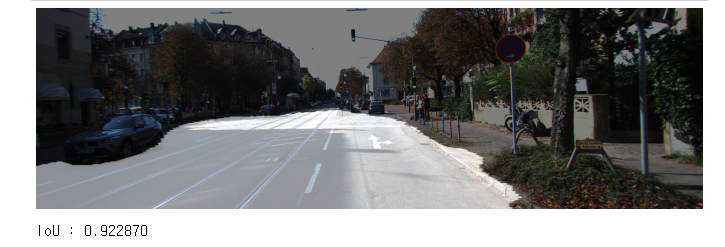

하지만 예상과 달리 더 성능이 떨어지는 모습을 보이고 있다

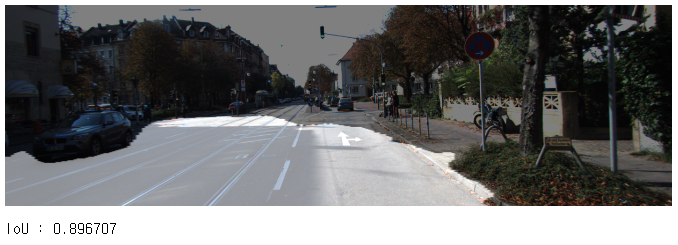

하지만 세부적으로 뜯어본다면 이전 학습결과를 보면 좀더 도로로 판단하는 임계값이 낮아 더 넓게 도로로 인식하는 것처럼 보이고

아래 비교 사진처럼 증강시 비율을 늘린 모델의 경우 인도에 대한 더 세부적인 분리 task능력은 올라간 것처럼 보인다

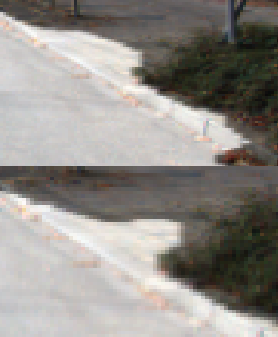

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
        self.on_epoch_end()  # Add this line to initialize indexes

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255.0
            outputs[i] = augmented["mask"]
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 기본 U-Net 모델 제작

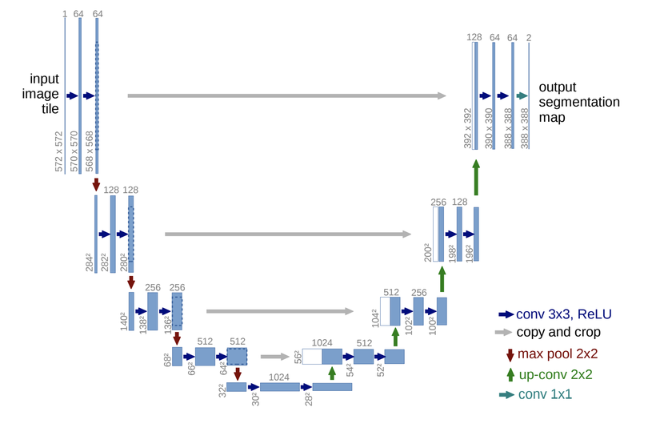

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, Dropout
from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    # 첫 타일
    inputs = Input(input_shape)
    
    # 인코더 레이어
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    # BottleNeck 레이어
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
    
    # 디코더 레이어
    u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 28s 765ms/step - loss: 0.6862 - val_loss: 0.6732
Epoch 2/100
11/11 [==============================] - 8s 695ms/step - loss: 0.6420 - val_loss: 0.6097
Epoch 3/100
11/11 [==============================] - 8s 699ms/step - loss: 0.6045 - val_loss: 0.5743
Epoch 4/100
11/11 [==============================] - 8s 711ms/step - loss: 0.5419 - val_loss: 0.4997
Epoch 5/100
11/11 [==============================] - 8s 716ms/step - loss: 0.4143 - val_loss: 0.3659
Epoch 6/100
11/11 [==============================] - 8s 724ms/step - loss: 0.3186 - val_loss: 0.3883
Epoch 7/100
11/11 [==============================] - 8s 715ms/step - loss: 0.3221 - val_loss: 0.2952
Epoch 8/100
11/11 [==============================] - 8s 713ms/step - loss: 0.2920 - val_loss: 0.2699
Epoch 9/100
11/11 [==============================] - 8s 709ms/step - loss: 0.2545 - val_loss: 0.3011
Epoch 10/100
11/11 [==============================] - 8s 699ms/step - loss: 0.2216 - val_l

11/11 [==============================] - 8s 698ms/step - loss: 0.1124 - val_loss: 0.1815
Epoch 82/100
11/11 [==============================] - 8s 697ms/step - loss: 0.1099 - val_loss: 0.1610
Epoch 83/100
11/11 [==============================] - 8s 697ms/step - loss: 0.1191 - val_loss: 0.1872
Epoch 84/100
11/11 [==============================] - 8s 701ms/step - loss: 0.1110 - val_loss: 0.1705
Epoch 85/100
11/11 [==============================] - 8s 700ms/step - loss: 0.0956 - val_loss: 0.1728
Epoch 86/100
11/11 [==============================] - 8s 700ms/step - loss: 0.0988 - val_loss: 0.1591
Epoch 87/100
11/11 [==============================] - 8s 702ms/step - loss: 0.1073 - val_loss: 0.1772
Epoch 88/100
11/11 [==============================] - 8s 699ms/step - loss: 0.1169 - val_loss: 0.1437
Epoch 89/100
11/11 [==============================] - 8s 699ms/step - loss: 0.0990 - val_loss: 0.2267
Epoch 90/100
11/11 [==============================] - 8s 698ms/step - loss: 0.1016 - val_loss: 

In [8]:
model = tf.keras.models.load_model(model_path)

In [9]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

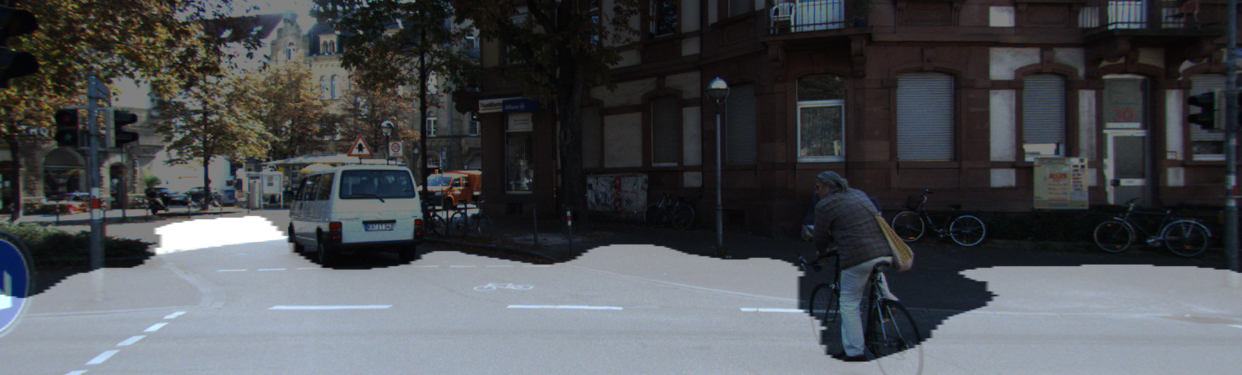

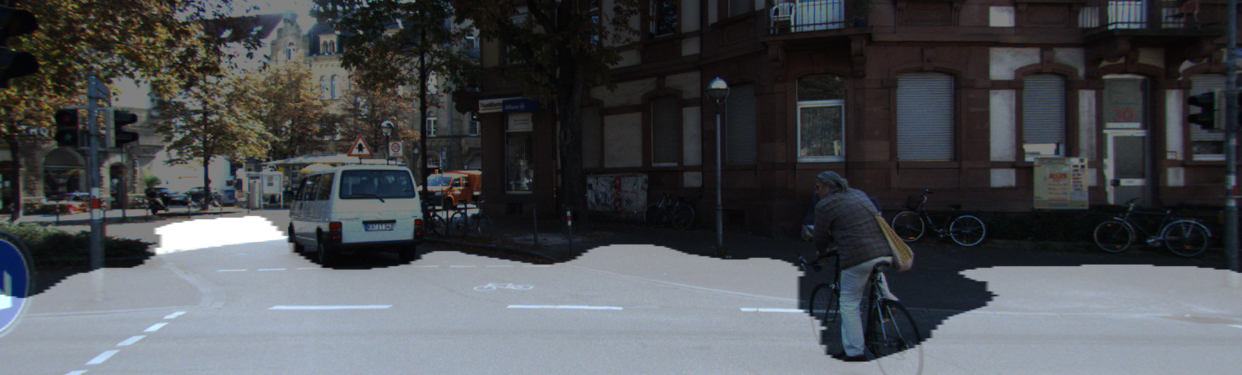

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):

    target = target.flatten()
    prediction = prediction.flatten()
    
    intersection = np.sum((target == 1) & (prediction == 1))
    union = np.sum((target == 1) | (prediction == 1))
    
    iou_score = intersection / union if union != 0 else 0.0
    print('IoU : %f' % iou_score)
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

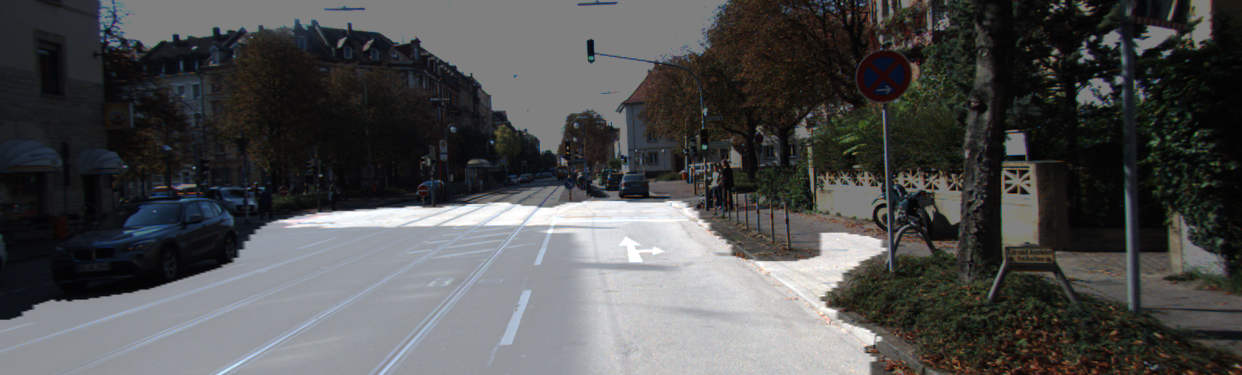

IoU : 0.893866


0.8938656280428432

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# U-Net++ 모델 구현 및 실행

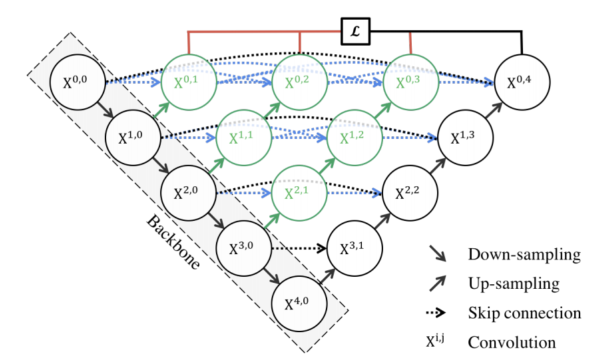

이전 단계에서 U-Net을 구현하고 그 결과를 분석해보았다.
이번엔 U-Net ++ 모델을 구현하고 그 결과를 비교해보겠다

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
# 기본 컨브, 업샘플링 등등 블록화

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(num_filters, (3,3), activation='relu', padding='same')(x)
    return x

def upsample_block(x, num_filters, method='transpose'):
    if method == 'transpose':
        x = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding='same')(x)
    else:
        x = UpSampling2D((2,2))(x)
        x = Conv2D(num_filters, (2,2), padding='same')(x)
    return x

def unetpp(input_shape=(224, 224, 3), num_filters = 64, num_classes=1):
    inputs = Input(input_shape)
    
    # 인코더
    c0_0 = conv_block(inputs, num_filters)
    p0_0 = MaxPooling2D((2, 2))(c0_0)
    
    c1_0 = conv_block(p0_0, num_filters * 2)
    p1_0 = MaxPooling2D((2, 2))(c1_0)
    
    c2_0 = conv_block(p1_0, num_filters * 4)
    p2_0 = MaxPooling2D((2, 2))(c2_0)
    
    c3_0 = conv_block(p2_0, num_filters * 8)
    p3_0 = MaxPooling2D((2, 2))(c3_0)
    
    c4_0 = conv_block(p3_0, num_filters * 16)
    
    # 디코더
    c3_1 = conv_block(concatenate([upsample_block(c4_0, num_filters * 8), c3_0]), num_filters * 8)
    c2_2 = conv_block(concatenate([upsample_block(c3_1, num_filters * 4), c2_0]), num_filters * 4)
    c1_3 = conv_block(concatenate([upsample_block(c2_2, num_filters * 2), c1_0]), num_filters * 2)
    c0_4 = conv_block(concatenate([upsample_block(c1_3, num_filters), c0_0]), num_filters)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c0_4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))

input_shape = (224, 224, 3)
model = unetpp(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [22]:
unetpp_history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
11/11 [==============================] - 10s 758ms/step - loss: 0.6411 - val_loss: 0.6154
Epoch 2/100
11/11 [==============================] - 8s 685ms/step - loss: 0.5757 - val_loss: 0.5174
Epoch 3/100
11/11 [==============================] - 8s 688ms/step - loss: 0.4265 - val_loss: 0.4395
Epoch 4/100
11/11 [==============================] - 8s 694ms/step - loss: 0.4033 - val_loss: 0.4078
Epoch 5/100
11/11 [==============================] - 8s 689ms/step - loss: 0.3351 - val_loss: 0.3849
Epoch 6/100
11/11 [==============================] - 8s 685ms/step - loss: 0.3546 - val_loss: 0.3765
Epoch 7/100
11/11 [==============================] - 8s 681ms/step - loss: 0.3321 - val_loss: 0.4214
Epoch 8/100
11/11 [==============================] - 8s 674ms/step - loss: 0.3375 - val_loss: 0.3964
Epoch 9/100
11/11 [==============================] - 8s 674ms/step - loss: 0.3120 - val_loss: 0.3722
Epoch 10/100
11/11 [==============================] - 8s 681ms/step - loss: 0.3286 - val_l

11/11 [==============================] - 7s 660ms/step - loss: 0.1601 - val_loss: 0.2752
Epoch 82/100
11/11 [==============================] - 8s 666ms/step - loss: 0.1613 - val_loss: 0.3082
Epoch 83/100
11/11 [==============================] - 8s 670ms/step - loss: 0.1827 - val_loss: 0.3082
Epoch 84/100
11/11 [==============================] - 8s 664ms/step - loss: 0.1852 - val_loss: 0.2438
Epoch 85/100
11/11 [==============================] - 8s 665ms/step - loss: 0.1682 - val_loss: 0.2262
Epoch 86/100
11/11 [==============================] - 8s 662ms/step - loss: 0.1624 - val_loss: 0.2537
Epoch 87/100
11/11 [==============================] - 8s 662ms/step - loss: 0.1622 - val_loss: 0.2679
Epoch 88/100
11/11 [==============================] - 7s 663ms/step - loss: 0.1707 - val_loss: 0.2638
Epoch 89/100
11/11 [==============================] - 8s 657ms/step - loss: 0.1514 - val_loss: 0.2846
Epoch 90/100
11/11 [==============================] - 8s 661ms/step - loss: 0.1642 - val_loss: 

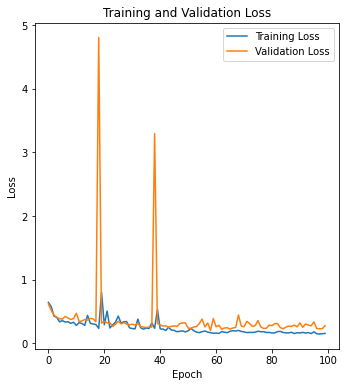

In [25]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
def plot_history(history):
    # 손실 시각화
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 결과를 시각화
plot_history(unetpp_history)

In [26]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

model.save(model_path)  #학습한 모델을 저장해 주세요.

In [27]:
model = tf.keras.models.load_model(model_path)

In [28]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

TypeError: get_output() missing 1 required positional argument: 'label_path'

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)